#We will build a linear regression model to predict flight price using 
##distance_km
##flights_per_week
## price
##days_operated
### now we will prepare a datset from our cleaned dataset to use in this Regression model

In [0]:
from pyspark.sql import functions as F
clean_df = spark.read.table(
    "workspace.eu_air_routes.eu_air_routes_clean"
)

ml_df = clean_df.select(
    "price",
    "distance_km",
    "flights_per_week",
    "days_operated"
).dropna()

display(
    ml_df.limit(5)
)


price,distance_km,flights_per_week,days_operated
70.0,1137.9340931605172,4.0,4
30.0,761.0563125794217,4.0,4
40.0,930.8054189555014,4.0,4
40.0,960.2224041388938,3.0,0
90.0,1288.7839485246104,3.0,0


## Assemble Features


In [0]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=["distance_km", "flights_per_week", "days_operated"],
    outputCol="features"
)

ml_df_filtered = ml_df.filter(F.col("price") < 2000)

ml_ready = assembler.transform(ml_df).select("features", "price")


## Train, test split

In [0]:
train_df, test_df = ml_ready.randomSplit([0.8, 0.2], seed=42)


## Verifying the new ml datset, train,test  schema

In [0]:

ml_ready.printSchema()

train_df.printSchema()
test_df.printSchema()


display(train_df.limit(5))
display(test_df.limit(5))


root
 |-- features: vectorudt (nullable = true)
 |-- price: double (nullable = true)

root
 |-- features: vectorudt (nullable = true)
 |-- price: double (nullable = true)

root
 |-- features: vectorudt (nullable = true)
 |-- price: double (nullable = true)



features,price
"{""type"":""1"",""size"":null,""indices"":null,""values"":[""23.19370966384762"",""2.0"",""2.0""]}",0.0
"{""type"":""1"",""size"":null,""indices"":null,""values"":[""38.801345582833974"",""20.0"",""7.0""]}",160.0
"{""type"":""1"",""size"":null,""indices"":null,""values"":[""53.08742840114148"",""2.0"",""2.0""]}",170.0
"{""type"":""1"",""size"":null,""indices"":null,""values"":[""53.08742840114148"",""2.0"",""3.0""]}",150.0
"{""type"":""1"",""size"":null,""indices"":null,""values"":[""57.5721248522533"",""14.0"",""7.0""]}",80.0


features,price
"{""type"":""1"",""size"":null,""indices"":null,""values"":[""44.780717202107056"",""8.0"",""4.0""]}",0.0
"{""type"":""1"",""size"":null,""indices"":null,""values"":[""60.32294747062307"",""2.0"",""2.0""]}",0.0
"{""type"":""1"",""size"":null,""indices"":null,""values"":[""65.06049390475836"",""1.0"",""0.0""]}",0.0
"{""type"":""1"",""size"":null,""indices"":null,""values"":[""81.91167569667908"",""12.0"",""7.0""]}",0.0
"{""type"":""1"",""size"":null,""indices"":null,""values"":[""92.47165500037772"",""2.0"",""2.0""]}",140.0


## Train Linera Regression model


In [0]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(labelCol="price", featuresCol="features")
model = lr.fit(train_df)


## Evaluate Model

In [0]:
predictions = model.transform(test_df)

print("Coefficients:", model.coefficients)
print("Intercept:", model.intercept)
print("RMSE:", model.summary.rootMeanSquaredError)
print("R2:", model.summary.r2)


Coefficients: [0.0663862031170093,0.2485488789094987,-1.4793932528051748]
Intercept: 1.2943627303161387
RMSE: 247.78753686865386
R2: 0.18204252288574052


## Visualization of prediction

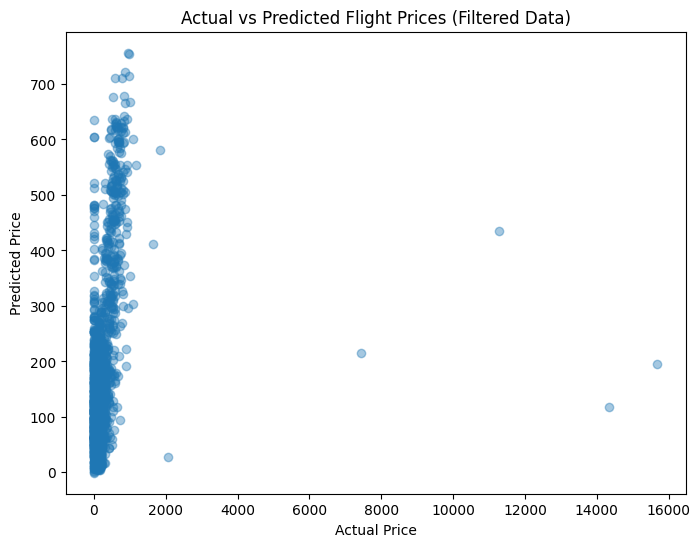

In [0]:
import matplotlib.pyplot as plt

pred_pdf = predictions.select("price", "prediction").toPandas()

plt.figure(figsize=(8,6))
plt.scatter(pred_pdf["price"], pred_pdf["prediction"], alpha=0.4)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Flight Prices (Filtered Data)")
plt.show()

